In [122]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import sklearn
import numpy as np
import matplotlib.pyplot as plt

Original df shape:  (1460, 80)
Any NaN in target:  False
df shape after dropping NaN columns:  (1460, 75)


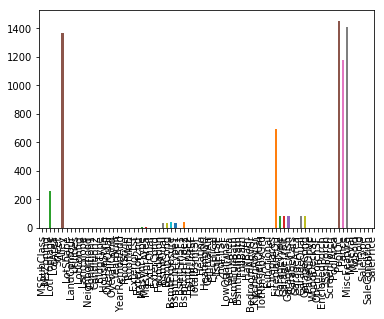

In [123]:
# Source & Data: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

path = "D:/git/House_price_predictor/"
df = pd.read_csv(os.path.join(path, 'train.csv'))
Id = df.pop('Id') # Remove the Id column
print('Original df shape: ', df.shape)
print('Any NaN in target: ', df['SalePrice'].isnull().values.any()) # Check if the target column has NaN
# Count the number of NaN in each column
na_count = df.isnull().sum()
# Visualize the count of NaN
na_count.plot.bar()
# Drop the columns with more than one third of NaN numbers
na_msk = na_count < df.shape[0]/3
df = df.loc[:,na_msk]
print('df shape after dropping NaN columns: ', df.shape)

In [124]:
# Find columns with non-digital element (object)
msk = df.dtypes == 'object'
colums_to_encode = df.loc[:,msk].columns.tolist()
# One hot encoding
df_encoded = pd.get_dummies(df, colums_to_encode)
print('df shape after one-hot encoding: ', df_encoded.shape)

df shape after one-hot encoding:  (1460, 271)


In [125]:
# Define X and y for the model input
y = df_encoded.pop('SalePrice').values
X = df_encoded.values
print('Shape of X: ', np.shape(X))
print('Shape of y: ', np.shape(y))

Shape of X:  (1460, 270)
Shape of y:  (1460,)


In [126]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print('Train set size: ', y_train.shape[0])
print('Validation set size: ', y_val.shape[0])
print('Test set size: ', y_test.shape[0])

Train set size:  876
Validation set size:  292
Test set size:  292


In [127]:
# Purify the data/ Handle NaN
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
X_train = my_imputer.fit_transform(X_train)
X_val = my_imputer.transform(X_val)
X_test = my_imputer.transform(X_test)

In [128]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=1000)
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_val, y_val)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

<BarContainer object of 10 artists>

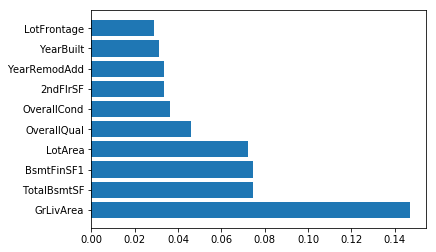

In [149]:
# Check the feature importances
features = df_encoded.columns.values.tolist()
importances = my_model.feature_importances_
feature_importances = pd.Series(importances, index = features)
feature_importances.sort_values(ascending=False, inplace=True)
# Plot the first 10 important features
plt.barh(feature_importances.index[:10], feature_importances[:10])

In [80]:
# make predictions
predictions = my_model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : ", mean_absolute_error(predictions, y_test))

Mean Absolute Error :  16974.6077964


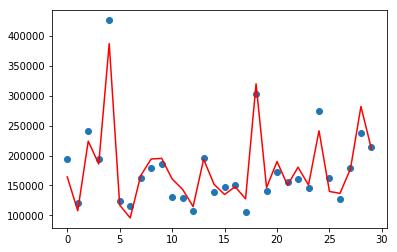

In [72]:
# Visualize the data and predictions
num_to_plot = 30
Id_test = np.arange(num_to_plot)
plt.scatter(Id_test, y_test[:num_to_plot])
plt.plot(Id_test, predictions[:num_to_plot], c='r')